<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> May 23, 2025 <strong>Author:</strong> Adnan Alaref
</div>

# **✅ Concept Introduction**

>### **Let's break down Categorical Focal Cross Entropy step by step in a simple way.**

# 🌟 Step 1: Start with Categorical Cross Entropy (CCE)

CCE is used in **multi-class classification** tasks — like predicting whether an image shows a **cat, dog, or bird**.

### 💡 How it works:

- Measures the difference between the predicted probabilities and the true class.
- Penalizes the model more when it's confident but **wrong**.

### 🧮 Formula:

$$
\text{CCE} = -\sum_{i=1}^{C} y_i \cdot \log(p_i)
$$

Where:

- \( C \): total number of classes  
- \( y_i \): 1 if class \( i \) is the true class, else 0  
- \( p_i \): model's predicted probability for class \( i \)

---

# 🔥 Step 2: Problem — CCE Struggles with Imbalanced Data

In real datasets, some classes are more frequent than others (e.g., 90% class 0, 10% class 1).  
Using CCE alone can cause the model to:

- Predict only the **majority class**
- Ignore rare but **important** classes

---

# 🎯 Step 3: Add “Focal” — Focus on Hard Examples

**Focal Loss** improves upon CCE by focusing more on **difficult (misclassified)** examples and less on **easy (correct)** ones.

### 🧮 Modulating factor:

$$
(1 - p_t)^ᵞ
$$

Where:

- \( p_t \): the predicted probability for the **true class**  
- \( γ ≥ 0 \): focusing parameter (commonly 2)

### 🔍 Behavior:

- \( p_t = 0.95 \) → \( (1 - p_t)^ᵞ ≈ 0.003 \): down-weighted (easy example)  
- \( p_t = 0.2 \) → \( (1 - p_t)^ᵞ = 0.8^ᵞ \): boosted (hard example)

---

# 🧠 Step 4: Categorical Focal Cross Entropy

Combine CCE with the modulating factor:

$$
\text{Focal Loss} = -\sum_{i=1}^{C} y_i ⋅ (1 - p_i)^ᵞ ⋅ \log(p_i)
$$

This:

- **Down-weights** easy examples  
- **Up-weights** hard examples

---

# ⚖️ Step 5: Add Class Weights — \( α \)

To handle **class imbalance**, we add a weighting factor \( α_i \) for each class:

- Higher weight for **rare** classes  
- Lower weight for **common** ones

### 📘 Final Formula:

$$
\text{Focal Loss} = -\sum_{i=1}^{C} α_i ⋅ y_i ⋅ (1 - p_i)^ᵞ ⋅ \log(p_i)
$$

Where:

- \( α_i ∈ [0, 1] \): weight assigned to class \( i \)  
- All other terms as before

---

### ✅ Summary Table

| Term         | Meaning                                 |
|--------------|------------------------------------------|
| \( y_i \)     | True class (1-hot)                      |
| \( p_i \)     | Model’s predicted probability for class \( i \) |
| \( γ \)  | Focus on hard examples                  |
| \( α_i \)| Class-specific weight                   |
| \( C \)       | Total number of classes                 |


## Let's Code

# **◍ Step 1: Import Libraries.**

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore' ,category=FutureWarning)

# **◍ Step 2: Compute alpha values.**

In [2]:
def compute_alpha(labels_or_counts ,num_classes = None):
  # If input is a tensor of labels
  if isinstance(labels_or_counts ,torch.Tensor) and labels_or_counts .dtype == torch.long:
    '''
     Is the input a PyTorch Tenso?
     Is that tensor made of integers, i.e., class indices like [0, 1, 2]?
    '''
    if num_classes == None:
      num_classes = int(labels_or_counts.max().item()) +1

    class_counts = torch.bincount(input = labels_or_counts ,minlength=num_classes).float()

  # If input is list/array of class counts
  else:
    class_counts = torch.tensor(labels_or_counts ,dtype=torch.float64)


  # Step 1: Calc inv_frq
  inv_frq = 1.0 / class_counts

  # Step 2: Normalize inv_frq
  alpha = inv_frq / inv_frq.sum()

  return alpha ,class_counts  # also return counts to test manulay

# **◍ Step 3: Compute Focal Loss.**

In [3]:
class FocalLoss(nn.Module):
  def __init__(self ,gamma= 2.0 ,alpha= None ,reduction = "mean"):
    super(FocalLoss ,self).__init__()

    self.gamma = gamma
    self.alpha = alpha # Should be a list or tensor of class weights

  def forward(self,inputs ,targets):
    # inputs: raw logits, shape (batch_size, num_classes)
    # targets: class indices, shape (batch_size,)
    num_classes = inputs.shape[1]

    # Convert logits to probabilities
    probs = F.softmax(inputs)
    safe_probs = torch.clamp(probs ,1e-7 ,1.0) # limit probs to prevent log(0)

    # One-hot encode targets
    y_true_one_hot = F.one_hot(targets ,num_classes=num_classes).float()

    # Compute standard cross entropy
    ce_loss = -y_true_one_hot * torch.log(safe_probs)

    # Compute focal factor
    focal_factor = ce_loss * (1 - safe_probs)**self.gamma

    # Alpha weighting
    if self.alpha is not None:
      alpha = torch.tensor(self.alpha).to(inputs.device)
      alpha_facotr =  alpha * y_true_one_hot
      loss = alpha_facotr * focal_factor * ce_loss
    else:
      loss = focal_factor * ce_loss

    if self.reduction == "mean":
      return loss.mean() # Average over batch
    elif self.reduction == "sum":
      return loss.sum()
    else:
      return loss

# **◍ Step 4: Check code.**

## ✅ Get number of samples in each class.

In [4]:
# In pandas
'''
import pandas as pd
df = pd.read_csv("Your path")
class_counts = df["label"].value_counts().sort_index().values
'''

# In torch
'''
import torch
labels = torch.tensor([0,1,2,3]) # Your target lables
num_classes = int(labels.max().item())+1
class_counts = torch.bincount(inputs = labels ,minlength=num_classes).float()  
# use it if we have row lables [0,1,1,2,3,3]
'''

'\nimport torch\nlabels = torch.tensor([0,1,2,3]) # Your target lables\nnum_classes = int(labels.max().item())+1\nclass_counts = torch.bincount(inputs = labels ,minlength=num_classes).float()  \n# use it if we have row lables [0,1,1,2,3,3]\n'

## ✅ Example 1: From raw labels

In [5]:
labels = torch.tensor([0, 0, 1, 2, 2, 2])  # 2x class 0, 1x class 1, 3x class 2
alpha = compute_alpha(labels,num_classes=3)
print(alpha)

(tensor([0.2727, 0.5455, 0.1818]), tensor([2., 1., 3.]))


## ✅ Example 2: From class counts

In [6]:
class_counts = [800, 150, 50]  # class imbalance
alpha = compute_alpha(class_counts)
print(alpha)

(tensor([0.0448, 0.2388, 0.7164], dtype=torch.float64), tensor([800., 150.,  50.], dtype=torch.float64))


## **📊 Visualize Class Imbalance.**

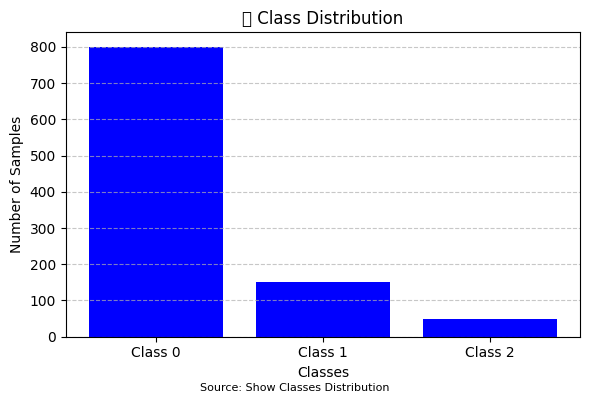

In [7]:
import matplotlib.pyplot as plt

# Simulate example class counts
alpha, class_counts = compute_alpha([800, 150, 50])
classes = [f'Class {i}' for i in range(len(class_counts))]

fig ,ax = plt.subplots(figsize = (6,4))

ax.bar(classes, class_counts.numpy(), color='blue')
plt.title("📊 Class Distribution")
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
fig.text(0.5 ,0.01 ,"Source: Show Classes Distribution",ha = "center",fontsize=8,color = "black")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **📈 Visualize Modulating Factor Behavior**

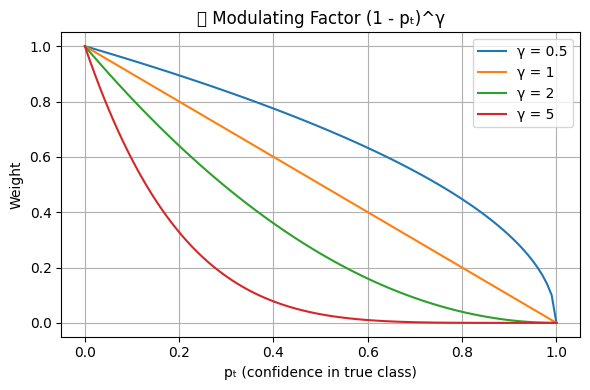

In [8]:
import numpy as np

p_t = np.linspace(0, 1, 100)
plt.figure(figsize=(6, 4))
for gamma in [0.5, 1, 2, 5]:
    plt.plot(p_t, (1 - p_t) ** gamma, label=f'γ = {gamma}')

plt.title('📈 Modulating Factor (1 - pₜ)^γ')
plt.xlabel('pₜ (confidence in true class)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **◍ Step 5: Test code.**

In [9]:
'''
size=100: generate 100 labels.
p=[0.5, 0.2, 0.1, 0.1, 0.1]: set the probability of each class.
Class 0: 50% → expected ~50 samples
Class 1: 20% → ~20 samples
Class 2, 3, 4: 10% each → ~10 samples each
'''
y_train = np.random.choice([0, 1, 2, 3, 4], size=100, p=[0.5, 0.2, 0.1, 0.1, 0.1])  # imbalanced labels
y_train

array([0, 1, 1, 0, 1, 2, 4, 3, 0, 1, 0, 4, 1, 3, 0, 0, 3, 2, 0, 1, 1, 3,
       3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 3, 2, 1, 0, 2, 0, 0, 0, 2, 0,
       0, 3, 1, 3, 1, 3, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 3, 2, 0, 0, 3,
       0, 2, 0, 0, 4, 0, 2, 0, 3, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 4, 4, 1, 3, 0, 4, 0, 3, 0, 1, 0])

In [10]:
alpha,counts = compute_alpha(torch.tensor(y_train), num_classes=5)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
alpha ,criterion   ,counts #

(tensor([0.0535, 0.1196, 0.2512, 0.1570, 0.4187]),
 FocalLoss(),
 tensor([47., 21., 10., 16.,  6.]))

# ✅ Conclusion
In real-world machine learning tasks—especially classification problems with imbalanced data—traditional loss functions like Categorical Cross Entropy can fall short. They tend to bias the model toward majority classes, leading to poor generalization on underrepresented categories.

To address this, Focal Loss introduces a dynamic scaling factor that down-weights easy examples and focuses the learning on hard, misclassified examples. When combined with class weights (α), it becomes a powerful tool for handling severe class imbalance.

In this notebook, we:

Broke down the intuition and mathematics behind Categorical Focal Loss step-by-step

Visualized how modulating factors behave under different conditions

Implemented a clean and reusable PyTorch version of Focal Loss

Explored how class imbalance can be quantified and corrected

By using Focal Loss, especially in tasks like medical diagnosis, fraud detection, or rare-event classification, practitioners can build models that are not just accurate—but fair and robust across all classes.

<a id="Import"></a>
<p style="background-color: #000000; font-family: 'Verdana', sans-serif; color: #FFFFFF; font-size: 160%; text-align: center; border-radius: 25px; padding: 12px 20px; margin-top: 20px; border: 2px solid transparent; background-image: linear-gradient(black, black), linear-gradient(45deg, #FF00FF, #00FFFF, #FFFF00, #FF4500); background-origin: border-box; background-clip: content-box, border-box; box-shadow: 0px 4px 20px rgba(255, 105, 180, 0.8);">
   Thanks & Upvote ❤️</p>